In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')
!mkdir /home/aistudio/external-libraries

!pip install Image -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached image-1.5.33-py2.py3-none-any.whl
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/96/82/0cbf62676f9d64dd0e73e1667ec6cc189bd52051ee85558081167010fdfa/Pillow-9.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/c3/68/b63abc009adee25c1bd266b3740e173eab656608cf21641594a37e02cf57/Django-3.2.13-py3-none-any.whl (7.9 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/af/6d/ea3a5c3027c3f14b0321cd4f7e594c776ebe64e4b927432ca6917512a4f7/asgiref-3.5.2-py3-none-any.whl (22 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/05/40/d836d55fb3f467243ee839ab7b814822fda522cd395fa41

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
from PIL import Image
import numpy as np
im = Image.open('data/train/images/01_test.jpg')
arr = np.array(im)

In [3]:
arr.min()

0

In [4]:
import os
import matplotlib.pyplot as plt
import sys 
import paddle
from paddle.io import Dataset
from PIL import Image
import numpy as np
train_image_path = 'data/train/images'
train_label_path = 'data/train/label'
BATCH_SIZE = 2
MIN_BOUND = 0
MAX_BOUND = 255
def listdir(path):
    '''返回目录下所有的文件，去掉一些常见的特殊目录，并通过相同的字典序保证两个文件名序列一一对应
    path: 目录
    '''
    files=os.listdir(path)
    if ".DS_Store" in files:
        files.remove(".DS_Store")
    if "checkpoint" in files:
        files.remove("checkpoint")
    files.sort()
    return files


def norm_img(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

class My_Dataset(Dataset):
    def __init__(self, image_path, label_path):
        super(My_Dataset, self).__init__()
        
        self.images = listdir(image_path)
        self.labels = listdir(label_path)
    def __getitem__(self, index):
        image = np.array(Image.open(os.path.join(train_image_path, self.images[index])).resize((1024, 1024), Image.ANTIALIAS))
        label = np.array(Image.open(os.path.join(train_label_path, self.labels[index])).resize((1024, 1024), Image.ANTIALIAS))
        
        
        #image = plt.imread(os.path.join(train_image_path, self.images[index])).astype('uint16')
        #label = plt.imread(os.path.join(train_label_path, self.labels[index])).astype('uint16')
        
        label = label.reshape([label.shape[0],label.shape[1],1])
        image = np.swapaxes(image,0,2)
        label = np.swapaxes(label,0,2)
        return norm_img(image), norm_img(label) 

    def __len__(self):
        return len(self.images)
train_Dataset = My_Dataset(train_image_path, train_label_path)
train_loader = paddle.io.DataLoader(train_Dataset, batch_size=BATCH_SIZE,shuffle=True)


In [5]:
for image, label in train_loader:
    break
print(image.shape)
print(label.shape)
from work.models.Unet import Unet
model = Unet(3,2)
paddle.summary(Unet(3,2), (1, 3, 1024, 1024))

[2, 3, 1024, 1024]
[2, 1, 1024, 1024]


W0601 17:17:03.708607 10553 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0601 17:17:03.714102 10553 gpu_context.cc:306] device: 0, cuDNN Version: 7.6.


-------------------------------------------------------------------------------
  Layer (type)         Input Shape           Output Shape         Param #    
    Conv2D-20      [[1, 3, 1024, 1024]]  [1, 64, 1024, 1024]       1,792     
  BatchNorm-19    [[1, 64, 1024, 1024]]  [1, 64, 1024, 1024]        256      
    Conv2D-21     [[1, 64, 1024, 1024]]  [1, 64, 1024, 1024]      36,928     
  BatchNorm-20    [[1, 64, 1024, 1024]]  [1, 64, 1024, 1024]        256      
  DoubleCovn-10    [[1, 3, 1024, 1024]]  [1, 64, 1024, 1024]         0       
    Pool2D-5      [[1, 64, 1024, 1024]]   [1, 64, 512, 512]          0       
    Conv2D-22      [[1, 64, 512, 512]]    [1, 128, 512, 512]      73,856     
  BatchNorm-21     [[1, 128, 512, 512]]   [1, 128, 512, 512]        512      
    Conv2D-23      [[1, 128, 512, 512]]   [1, 128, 512, 512]      147,584    
  BatchNorm-22     [[1, 128, 512, 512]]   [1, 128, 512, 512]        512      
  DoubleCovn-11    [[1, 64, 512, 512]]    [1, 128, 512, 512]  

{'total_params': 31055362, 'trainable_params': 31031810}

In [7]:
from paddle import fluid
import paddle.nn.functional as F
#from hausdorff import hausdorff_distance
def create_loss(predict, label, num_classes=1):
    ''' 创建loss，结合dice和交叉熵 '''
    #predict:BATCH_SIZE,2,512,512
    predict = fluid.layers.transpose(predict, perm=[0, 2, 3, 1])#batch_size,512,512,2
    predict = fluid.layers.reshape(predict, shape=[-1, num_classes])
    predict = fluid.layers.softmax(predict)
    label = paddle.cast(label,'int64')
    label = fluid.layers.reshape(label, shape=[-1, 1])
    ce_loss = fluid.layers.cross_entropy(predict, label) # 计算交叉熵
    #dice_loss = fluid.layers.dice_loss(predict,label)
    #return fluid.layers.reduce_mean(ce_loss + dice_loss) # 最后使用的loss是dice和交叉熵的和，单独使用dice一般不是很稳定
    return fluid.layers.reduce_mean(ce_loss)
def mean_iou(pred, label, num_classes=2):
    ''' 计算miou，评价网络分割结果的指标'''
    pred = fluid.layers.argmax(pred, axis=1)
    pred = fluid.layers.cast(pred, 'int32')
    label = fluid.layers.cast(label, 'int32')
    miou, wrong, correct = fluid.layers.mean_iou(pred, label, num_classes)
    return miou

In [9]:
EPOCH = 32
input_channels = 3
out_filiters = 2


optim_RMS = paddle.optimizer.RMSProp(learning_rate=0.0005, 
                                 rho=0.9, 
                                 momentum=0.3, 
                                 epsilon=1e-07, 
                                 centered=False,
                                 parameters=model.parameters())
optim_Adam = paddle.optimizer.Adam(learning_rate=0.0005,
                                   parameters=model.parameters(),
                                   )
loss_list_RMS = []
for e in range(EPOCH):
    for i, (image,label) in enumerate(train_loader):
        image = image.astype('float32')
        out = model(image)
        label = paddle.cast(label, 'float32')
        loss = create_loss(out, label, num_classes=2)
        if i % 500 == 0:
            mIOU = mean_iou(out,label,num_classes=2)
            print("Epoch {} batch {}: mIOU:{}".format(e, i, mIOU))
        avg_loss = paddle.mean(loss)
        avg_loss.backward()
        optim_RMS.minimize(avg_loss)
        model.clear_gradients()
        if i % 10 == 0:
            print("Epoch {} batch {}: loss = {}".format(e, i, np.mean(loss.numpy())))
    if e % 5 == 0:
        print("Epoch {} batch {}: loss = {}".format(e, i, np.mean(loss.numpy())))
    #    paddle.save(net.state_dict(),'Unet_epoch{}.pdparams'.format(e))

Epoch 0 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.46817333])
Epoch 0 batch 0: loss = 0.49217450618743896
Epoch 0 batch 9: loss = 0.2166280895471573
Epoch 1 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.48832560])
Epoch 1 batch 0: loss = 0.20361608266830444
Epoch 2 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.49228010])
Epoch 2 batch 0: loss = 0.24579831957817078
Epoch 3 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.46401390])
Epoch 3 batch 0: loss = 0.23891450464725494
Epoch 4 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.62983036])
Epoch 4 batch 0: loss = 0.10734071582555771
Epoch 5 batch 0: mIOU:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.81147420])
Epoch 5 batch 0: loss = 0.095881186425685

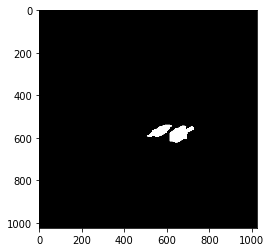

In [12]:
plt.imshow(label[0][0].numpy(), cmap='gray')


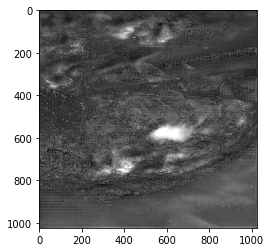

In [14]:
plt.imshow(out[0][1].numpy(), cmap='gray')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


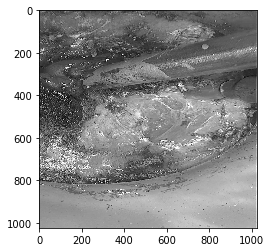

In [16]:
plt.imshow(image[0][0].numpy(), cmap='gray')